# Examination of Actual Mortality vs Predicted Mortality (Based on APACHE score)
* APACHE is an aggregrate score to determine severity of a disease
* It is often used by doctors as a risk assessment score and to guide their decisions

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np

In [2]:
rawdata = pd.read_csv('Downloads/bq-results-20190721-131729-1qysper8g9lb.csv')

FileNotFoundError: [Errno 2] File b'Downloads/bq-results-20190721-131729-1qysper8g9lb.csv' does not exist: b'Downloads/bq-results-20190721-131729-1qysper8g9lb.csv'

In [3]:
cols = rawdata.columns.to_list()
exclude_col = ['patientunitstayid','unitdischargestatus','unitdischargeoffset',
               'icu_los_hours','patienthealthsystemstayid','unittype',
               'vasopressin', 'vancomycin', 'norephinephrine', 'epinephrine', 'ketorolac', 'ibuprofen',
               'predictedicumortality', 'actualicumortality',
               'LACTATE_max', 'LACTATE_min', 'HCO3_min', 'HCO3_max','ALBUMIN_min', 'ALBUMIN_max',
               'PTT_max', 'PTT_min', 'ANIONGAP_min', 'ANIONGAP_max','INR_max', 'INR_min',
               'BILIRUBIN_max', 'BILIRUBIN_min', 'FiO2', 'gender','ph'
              ]
for col in exclude_col:
    cols.remove(col)

In [4]:
# select columns
data = rawdata[cols].copy(deep=True)
data['predictedicumortality'] = rawdata['predictedicumortality'].copy(deep=True)
data['actualicumortality'] = rawdata['actualicumortality'].copy(deep=True)

## Feature Selection & Cleaning

In [5]:
log_cols = ['CREATININE_min', 'CREATININE_max', 'BUN_min', 'BUN_max',
       'POTASSIUM_min', 'POTASSIUM_max', 'HCO3_min', 'HCO3_max', 'ALBUMIN_min',
       'ALBUMIN_max', 'CHLORIDE_min', 'CHLORIDE_max', 'LACTATE_max',
       'LACTATE_min', 'PTT_max', 'PTT_min', 'SODIUM_min', 'SODIUM_max',
       'ANIONGAP_min', 'ANIONGAP_max', 'PLATELET_max', 'PLATELET_min',
       'heartrate_max', 'heartrate_min', 'AVG_HEART_RATE', 'resprate_max',
       'resprate_min', 'AVG_RESPRATE', 'nibp_diastolic_max',
       'nibp_diastolic_min', 'AVG_NIBP_DBP', 'nibp_systolic_max',
       'nibp_systolic_min', 'AVG_NIBP_SBP', 'temp_max', 'temp_min', 'AVG_TEMP',
       'BICARBONATE_min', 'BICARBONATE_max', 'INR_max', 'INR_min',
       'GLUCOSE_max', 'GLUCOSE_min', 'BILIRUBIN_max', 'BILIRUBIN_min', 'FiO2']

for col_to_remove in ['LACTATE_max', 'LACTATE_min', 'HCO3_min', 'HCO3_max','ALBUMIN_min', 'ALBUMIN_max', 
               'PTT_max', 'PTT_min', 'ANIONGAP_min', 'ANIONGAP_max','INR_max', 'INR_min',
               'BILIRUBIN_max', 'BILIRUBIN_min', 'FiO2']:
    log_cols.remove(col_to_remove)

In [6]:
for col in data.columns:
    print(col, 'no. of nans:', len(data[col]) - data[col].count())

age no. of nans: 0
apache_iv no. of nans: 0
apachescore no. of nans: 0
dialysis no. of nans: 0
CREATININE_min no. of nans: 242
CREATININE_max no. of nans: 242
BUN_min no. of nans: 241
BUN_max no. of nans: 241
POTASSIUM_min no. of nans: 290
POTASSIUM_max no. of nans: 290
CHLORIDE_min no. of nans: 309
CHLORIDE_max no. of nans: 309
SODIUM_min no. of nans: 237
SODIUM_max no. of nans: 237
PLATELET_max no. of nans: 431
PLATELET_min no. of nans: 431
heartrate_max no. of nans: 584
heartrate_min no. of nans: 584
AVG_HEART_RATE no. of nans: 584
resprate_max no. of nans: 640
resprate_min no. of nans: 640
AVG_RESPRATE no. of nans: 640
nibp_diastolic_max no. of nans: 812
nibp_diastolic_min no. of nans: 812
AVG_NIBP_DBP no. of nans: 812
nibp_systolic_max no. of nans: 811
nibp_systolic_min no. of nans: 811
AVG_NIBP_SBP no. of nans: 811
temp_max no. of nans: 242
temp_min no. of nans: 242
AVG_TEMP no. of nans: 242
BICARBONATE_min no. of nans: 560
BICARBONATE_max no. of nans: 560
GLUCOSE_max no. of nans

In [7]:
# drop rows with any missing data
data_dropna = data.dropna().copy(deep=True)

In [8]:
data_dropna = data_dropna.loc[(data_dropna[log_cols] > 0).all(axis=1)]

In [9]:
# apply log to measurements to transform into more Gaussian-like shape
data_dropna [log_cols] = np.log(data_dropna[log_cols])

# drop rows where predictedicumortality is -1
data_dropna = data_dropna.loc[data_dropna['predictedicumortality'] >= 0]

In [10]:
data_dropna.head(2)

,age,apache_iv,apachescore,dialysis,CREATININE_min,CREATININE_max,BUN_min,BUN_max,POTASSIUM_min,POTASSIUM_max,...,temp_max,temp_min,AVG_TEMP,BICARBONATE_min,BICARBONATE_max,GLUCOSE_max,GLUCOSE_min,total_urineoutput,predictedicumortality,actualicumortality
0,66.0,68,68,0,-0.174353,0.215111,2.708050,2.944439,1.223775,1.435085,...,3.618993,3.597312,3.608889,2.995732,3.178054,5.620401,4.543295,850.0,0.066750,ALIVE
1,89.0,78,78,0,0.536493,0.548121,3.295837,3.367296,1.335001,1.458615,...,3.605498,3.594569,3.600949,3.178054,3.258097,4.744932,4.663439,1475.0,0.036109,ALIVE


## Data Normalization

In [20]:
# normalize guassian
data_norm = pd.DataFrame()
for col in data:
    # exclude certain columns
    if col not in ["actualicumortality", "dialysis","predictedicumortality"]:
        cmean = data_dropna[col].mean()
        cstd = data_dropna[col].std()
        data_norm[col] = (data_dropna[col] - cmean)/cstd

# add columns that don't need normalizing
data_norm['dialysis'] = data_dropna['dialysis']
data_norm['actualicumortality'] = data_dropna['actualicumortality']
data_norm['predictedicumortality'] = data_dropna['predictedicumortality']

In [147]:
for col in data_norm.columns:
    print(col)

age
apache_iv
apachescore
CREATININE_min
CREATININE_max
BUN_min
BUN_max
POTASSIUM_min
POTASSIUM_max
CHLORIDE_min
CHLORIDE_max
SODIUM_min
SODIUM_max
PLATELET_max
PLATELET_min
heartrate_max
heartrate_min
AVG_HEART_RATE
resprate_max
resprate_min
AVG_RESPRATE
nibp_diastolic_max
nibp_diastolic_min
AVG_NIBP_DBP
nibp_systolic_max
nibp_systolic_min
AVG_NIBP_SBP
temp_max
temp_min
AVG_TEMP
BICARBONATE_min
BICARBONATE_max
GLUCOSE_max
GLUCOSE_min
total_urineoutput
dialysis
actualicumortality
predictedicumortality
group


In [146]:
data_norm['dialysis'].value_counts()

0    7479
1     375
Name: dialysis, dtype: int64

In [22]:
data_norm['actualicumortality'] = data_norm['actualicumortality'].map({'ALIVE': 0, 'EXPIRED': 1}).astype(int)

In [136]:
pd.plotting.scatter_matrix(data_norm, alpha=0.2, figsize=(12, 12), diagonal='hist')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7facd1954488> (for post_execute):


KeyboardInterrupt: 

In [23]:
from sklearn import decomposition
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

In [25]:
# put data into np array
X = np.array(data_norm[data_norm.columns[:-3]])
D = np.array(data_norm['dialysis'])
M = np.array(data_norm['actualicumortality'])

## PCA to reduce dimensions to 10

In [148]:
pca = decomposition.PCA(n_components=10)
pca.fit(X)
X_tr = pca.transform(X)
######
# X_tr = X

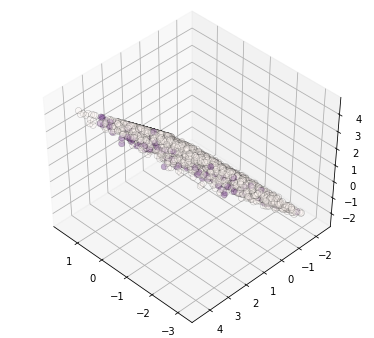

In [105]:
fig = plt.figure(figsize = (5,4.5))
ax = Axes3D(fig, elev=45, azim=135)
ax.scatter(X_tr[:,0], X_tr[:,1],X_tr[:,2], s=40, linewidths=0.4, alpha=0.3,
           c=D, cmap="RdPu", edgecolors='black')
plt.show()

## Patient Segmentation using K-means, after PCA

In [149]:
km = KMeans(n_clusters=6, random_state=66).fit(X_tr)

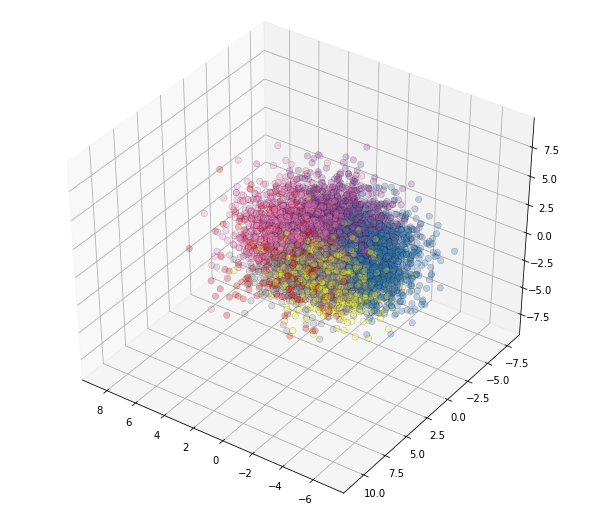

In [152]:
fig = plt.figure(figsize = (8,7))
ax = Axes3D(fig, elev=40, azim=125)
ax.scatter(X_tr[:,0], X_tr[:,1],X_tr[:,2], s=40, linewidths=0.4, alpha=0.3,
           c=km.labels_, cmap="Set1", edgecolors='black')
plt.show()

## Comparison of actual mortality vs predicted mortality (prediction made by ICUs) of groups

In [108]:
data_norm['group'] = km.labels_
results = data_norm.groupby(['group','dialysis']).mean()[['actualicumortality','predictedicumortality']]
results['change'] = results['actualicumortality'] - results['predictedicumortality']
results

actualicumortality  predictedicumortality    change
group dialysis                                                     
0     0                   0.087805               0.135174 -0.047369
      1                   0.131387               0.173362 -0.041975
1     0                   0.051923               0.087767 -0.035844
      1                   0.026316               0.083746 -0.057430
2     0                   0.063392               0.104521 -0.041128
      1                   0.187500               0.169277  0.018223
3     0                   0.221294               0.289671 -0.068377
      1                   0.357143               0.493879 -0.136736
4     0                   0.064608               0.065313 -0.000705
      1                   0.076923               0.092997 -0.016074
5     0                   0.525735               0.632082 -0.106347
      1                   0.297872               0.602370 -0.304498

In [109]:
results['change'].unstack()

dialysis,0,1
group,,
0,-0.047369,-0.041975
1,-0.035844,-0.057430
2,-0.041128,0.018223
3,-0.068377,-0.136736
4,-0.000705,-0.016074
5,-0.106347,-0.304498


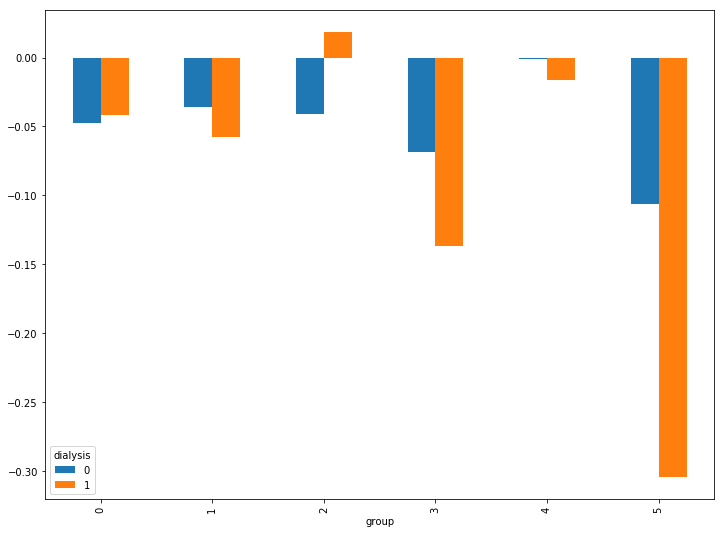

In [157]:
results['change'].unstack().plot.bar(figsize=(12,9))

## Compare group 2 with the rest

In [161]:
data_dropna['group'] = km.labels_
grp2 = data_dropna.loc[data_dropna['group'] == 2]
grp2 = grp2[grp2.columns[:-4]]
grpn = data_dropna.loc[data_dropna['group'] != 2]
grpn = grpn[grpn.columns[:-4]]

In [116]:
grp2 = data_norm.loc[data_norm['group'] == 2]
grp2 = grp2[grp2.columns[:-4]]
grpn = data_norm.loc[data_norm['group'] != 2]
grpn = grpn[grpn.columns[:-4]]

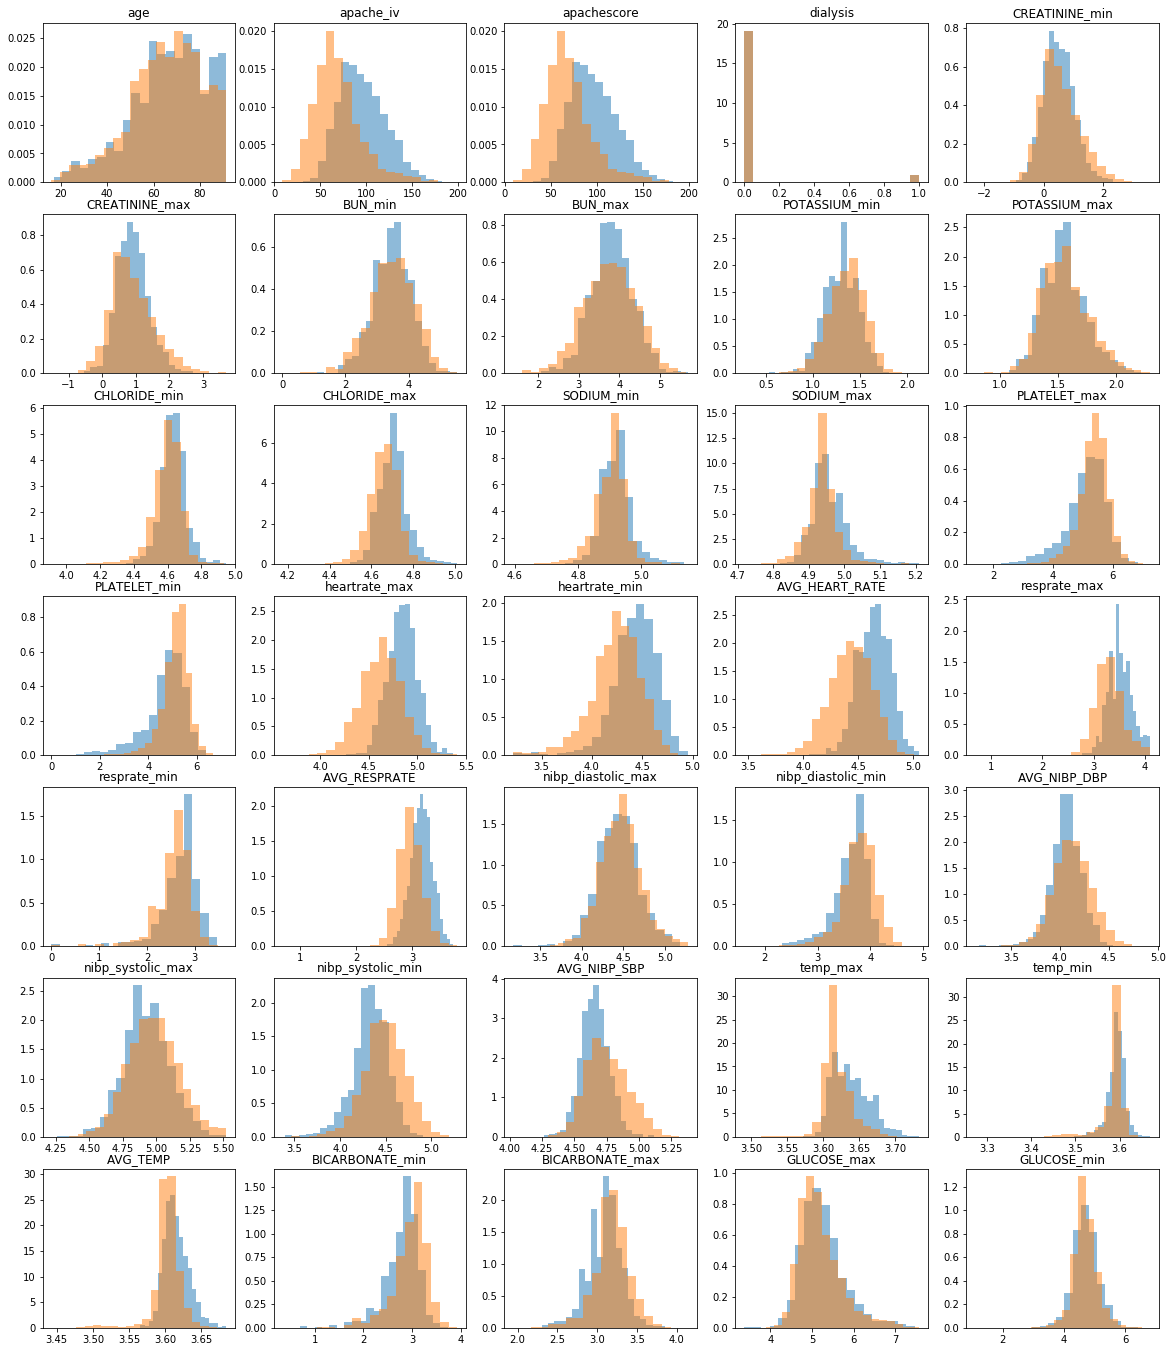

In [162]:
fig, ax = plt.subplots(7,5, figsize=(20,24))

col_id = 0
for i in range(7):
    for j in range(5):
        col_to_plot = grp2.columns[col_id]
        ax[i][j].hist(grp2[col_to_plot], density=True, alpha=0.5, bins=20)
        ax[i][j].hist(grpn[col_to_plot], density=True, alpha=0.5, bins=20)
        ax[i][j].set_title(col_to_plot)
        col_id+=1
plt.show
plt.savefig('grp2_vs_rest.png')

---

### notes: **apachescore vs dialysis decisions**

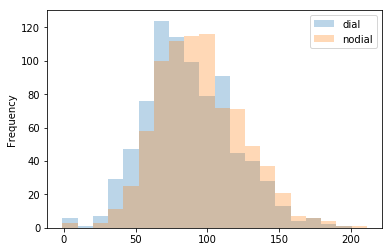

In [248]:
test = pd.DataFrame()
test['dial'] = data_dropna.loc[data_dropna['dialysis'] == 1,'apachescore'].reset_index(drop=True)
test['nodial'] = data_dropna.loc[data_dropna['dialysis'] == 0,'apachescore'].reset_index(drop=True)
test.plot.hist(bins=20, alpha=0.3)

In [249]:
test.mean()

dial      87.118227
nodial    94.891626
dtype: float64